## Prioritized Experience Replay
__[Paper link](https://arxiv.org/pdf/1511.05952.pdf)__

In [1]:
import gym
import torch
from torch import nn #needed for building neural networks
import torch.nn.functional as F #needed for activation functions
import torch.optim as opt #needed for optimisation
from tqdm import tqdm_notebook as tqdm
import random
from copy import copy, deepcopy
from collections import deque
import numpy as np
print("Using torch version: {}".format(torch.__version__))

Using torch version: 1.1.0


In [2]:
# Neural network parameters

lra = 0.0001  # learning rate for the actor
lrc = 0.001   # learning rate for the critic

optimizer = 'Adam'  #optimizer is Adam 

# for Q 
l2_decay = 0.01  # L2 weight of decay
gamma = 0.99     # discount factor

# soft target updates
tau = 0.001

# low dimensional neural networks
layer_1 = 400
layer_2 = 300 

# memory parameters
mini_batch = 64
memory_size = 100000

env_name = "Pendulum-v0" 

episodes = 5000
steps = 200

epsilon = 1
epsilon_decay = 1./100000

In [3]:
# neural networks use rectified non-linearity for hidden layers
# final output layer of actor is a tanh layer bound to the actions
# actions not included until 2nd hidden layer of Q

In [4]:
# sum tree code from: 
# https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
# https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Dueling%20Double%20DQN%20with%20PER%20and%20fixed-q%20targets/Dueling%20Deep%20Q%20Learning%20with%20Doom%20(%2B%20double%20DQNs%20and%20Prioritized%20Experience%20Replay).ipynb

import numpy

class SumTree(object):
    data_pointer = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros( 2*capacity - 1 )
        self.data = numpy.zeros( capacity, dtype=object )

    def add(self, priority, data):
        tree_index = self.data_pointer + self.capacity -1  # get the index we want to use

        self.data[self.data_pointer] = data   # update the data
        self.update(tree_index, priority)   # update the leaf

        self.data_pointer += 1     #increase the pointer
        
        if self.data_pointer >= self.capacity: # at capacity, go back to zero
            self.data_pointer = 0

    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index] # new priority - old priority

        self.tree[tree_index] = priority
        
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2 # gets the node above the index
            self.tree[tree_index] += change

    def get_leaf(self, v):
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            if left_child_index >= len(self.tree): # end at the bottom
                leaf_index = parent_index
                break
            else: # do a downward search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
        data_index = leaf_index - self.capacity + 1
        
        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    def total_priority(self):
        return self.tree[0] # returns the root node
        

In [5]:
# Memory code adapted from sumtree sources and-->
# https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py


class Memory(object):   # stored as ( s, a, r, t, s_ ) in SumTree
    
    e = 0.01    # hyperparameter to avoid experience having 0 probability of being sampled
    a = 0.6     # hyperparameter for choosing high priority versus random sampling
    b = 0.4     # importance sampling, from intial value increasing to 1
    b_increment = 0.001
    abs_error_upper = 1. # clipped abs error
    
    def __init__(self, capacity):  # create the tree
        self.tree = SumTree(capacity)

    def store(self, experience):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:]) # locate the max priority
        
        if max_priority == 0: # can't have a priority of 0 or it will never be used, set the minimum priority.
            max_priority = self.abs_error_upper
        
        self.tree.add(max_priority, experience)  # set the max p for the new priority
        
    def sample(self, n):
        memory_b = [] # array to contain mini-batch
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)
        
        # divide the range into n ranges (see prioritized experience replay paper)
        priority_segment = self.tree.total_priority() / n
        
        # increase the amount of samples that use priority versus random
        self.b = np.min([1., self.b + self.b_increment]) # one is the max
        
        # calculate teh max weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority()
        max_weight = (p_min * n) ** (-self.b)
    
        for i in range(n):
            # sample uniformly from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a,b)
            
            # experience for each value is retrieved
            index, priority, data = self.tree.get_leaf(value)
            
            sampling_probabilities = priority / self.tree.total_priority()
            
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.b) / max_weight
            
            b_idx[i] = index
            experience = [data]
            
            memory_b.append(experience)
        
        return b_idx, memory_b, b_ISWeights
    
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.e # avoid zeros
        clipped_errors = np.minimum(abs_errors, self.abs_error_upper)
        ps = np.power(clipped_errors, self.a)
        
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

In [6]:
# memory is empty- so prepopulate with random actions
memory = Memory(memory_size)
env = gym.make(env_name)

for i in range (memory_size):
    state_1 = env.reset()
    for t in range(200):
        action = env.action_space.sample()
        state_2, reward, done, info = env.step(action)
        
        if done: 
            #state_2 = np.zeros(state.shape())
            
            experience = (state_1, action, reward, done, state_2)
            memory.store(experience)
            
            t = 200
        
        else:
            experience = (state_1, action, reward, done, state_2)
            memory.store(experience) 

            state_1 = state_2


In [7]:
# can't use gpu on virtual box
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [8]:
def fanin_(size):
    fan_in = size[0]
    weight = 1./np.sqrt(fan_in)
    return torch.Tensor(size).uniform_(-weight, weight)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, h1=layer_1, h2=layer_2, init_w=3e-3):
        super(Critic, self).__init__()
                
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        
        #self.bn1 = nn.BatchNorm1d(h1)
        
        self.linear2 = nn.Linear(h1+action_dim, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
                
        self.linear3 = nn.Linear(h2, 1)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        
    def forward(self, state, action):
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(torch.cat([x,action],1))        
        x = self.relu(x)
        x = self.linear3(x)
        
        return x
    

class Actor(nn.Module): 
    def __init__(self, state_dim, action_dim, h1=layer_1, h2=layer_2, init_w=0.003):
        super(Actor, self).__init__()
        
        #self.bn0 = nn.BatchNorm1d(state_dim)
        
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        
        #self.bn1 = nn.BatchNorm1d(h1)
        
        self.linear2 = nn.Linear(h1, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
        
        #self.bn2 = nn.BatchNorm1d(h2)
        
        self.linear3 = nn.Linear(h2, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, state):
        #state = self.bn0(state)
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.tanh(x)
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0]

In [9]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu=0, sigma=0.2, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [10]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [11]:
#env = NormalizedEnv(gym.make(env_name))



state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("State dim: {}, Action dim: {}".format(state_dim, action_dim))

noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

critic  = Critic(state_dim, action_dim).to(device)
actor = Actor(state_dim, action_dim).to(device)

target_critic  = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)

for target_param, param in zip(target_critic.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_actor.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
    
q_optimizer  = opt.Adam(critic.parameters(),  lr=lrc)#, weight_decay=0.01)
policy_optimizer = opt.Adam(actor.parameters(), lr=lra)

MSE = nn.MSELoss()

# memory = Memory(replay_buffer)

State dim: 3, Action dim: 1


In [12]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

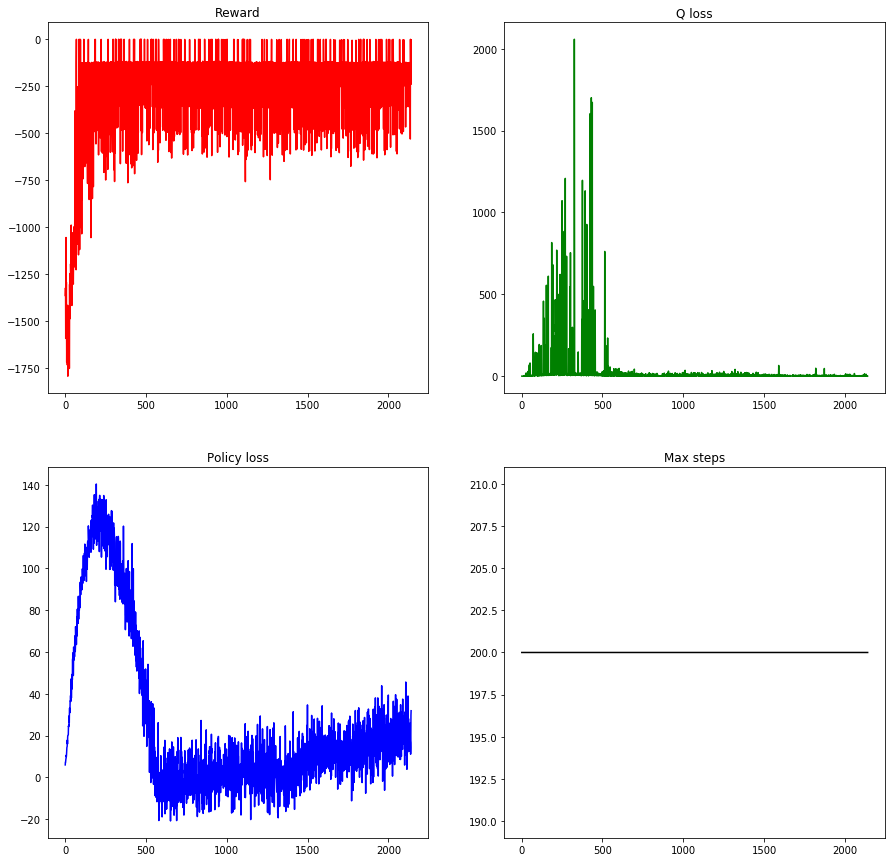

[  2140 episode,   428000 total steps] average reward for past 10 iterations: -163.936
Last model saved with reward: -0.03, at episode 1848.


KeyboardInterrupt: 

In [13]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
#s = deepcopy(env.reset())
PRINT_EVERY = 10 
buffer_start = 100

for episode in range(episodes): 
    #print(episode)
    s = deepcopy(env.reset())
    #noise.reset()

    ep_reward = 0.
    ep_q_value = 0.
    step=0

    for step in range(steps):
        #loss=0
        global_step +=1
        epsilon -= epsilon_decay
        #actor.eval()
        a = actor.get_action(s)
        #actor.train()

        a += noise()*max(0, epsilon)
        a = np.clip(a, -1., 1.)
        s2, reward, terminal, info = env.step(a)


        memory.store((s, a, reward, terminal,s2))

        #keep adding experiences to the memory until there are at least minibatch size samples
        
        if True: # memory.count() > buffer_start:
            index, batch, weights = memory.sample(mini_batch)
            
            # put in numpy array first, then send numpy array to tensor.
            # might be a better way, but I didn't want to research...
            states_mb = np.array([each[0][0] for each in batch], ndmin=3)
            actions_mb = np.array([each[0][1] for each in batch])
            rewards_mb = np.array([each[0][2] for each in batch]) 
            dones_mb = np.array([each[0][3] for each in batch])   
            next_states_mb = np.array([each[0][4] for each in batch], ndmin=3)

            s_batch = torch.FloatTensor(states_mb).squeeze(0).to(device)
            a_batch = torch.FloatTensor(actions_mb).squeeze(0).to(device)
            r_batch = torch.FloatTensor(rewards_mb).unsqueeze(1).to(device)
            t_batch = torch.FloatTensor(np.float32(dones_mb)).unsqueeze(1).to(device)
            s2_batch = torch.FloatTensor(next_states_mb).squeeze(0).to(device)
            
            
            
            
            #compute loss for critic
            a2_batch = target_actor(s2_batch)
            target_q = target_critic(s2_batch, a2_batch) #detach to avoid updating target
            y = r_batch + (1.0 - t_batch) * gamma * target_q.detach()
            q = critic(s_batch, a_batch)
            
            q_optimizer.zero_grad()
            q_loss = MSE(q, y) #detach to avoid updating target
            q_loss.backward()
            q_optimizer.step()
            
            #compute loss for actor
            policy_optimizer.zero_grad()
            policy_loss = -critic(s_batch, actor(s_batch))
            policy_loss = policy_loss.mean()
            policy_loss.backward()
            policy_optimizer.step()
            
            #soft update of the frozen target networks
            for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - tau) + param.data * tau
                )

            for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - tau) + param.data * tau
                )

        s = deepcopy(s2)
        ep_reward += reward


        #if terminal:
        #    noise.reset()
        #    break

    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.data, episode+1])
        plot_q.append([q_loss.data, episode+1])
        plot_steps.append([step+1, episode+1])

    except:
        continue
        
    average_reward += ep_reward
    
    if ep_reward > best_reward:
        torch.save(actor.state_dict(), 'best_model_pendulum_prio.pkl') #Save the actor model for future testing
        best_reward = ep_reward
        saved_reward = ep_reward
        saved_ep = episode+1


    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        subplot(plot_reward, plot_policy, plot_q, plot_steps)
        print('[%6d episode, %8d total steps] average reward for past {} iterations: %.3f'.format(PRINT_EVERY) %
              (episode + 1, global_step, average_reward / PRINT_EVERY))
        print("Last model saved with reward: {:.2f}, at episode {}.".format(saved_reward, saved_ep))
        average_reward = 0 #reset average reward